In [1]:
import os
os.chdir("../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']=str(2)


In [39]:
import flax.linen as nn
import jax
import jax.numpy as jnp
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import tqdm
from flax.training import train_state
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
# from utilities import plot

import tensorflow_probability.substrates.jax as tfp

dist = tfp.distributions

from datasets.dataset_loader import dataset_load
from utilities import plot,fits,gmm,errors,predict,preprocess


In [4]:
# dataset = pd.read_csv("NILM_data_basic.csv")
# dataset = dataset.drop(['Washer Dryer','Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'], axis=1)
# dataset.dropna(inplace=True)

In [5]:
# def call_preprocessing(x, y, scaler_x = None, scaler_y = None, method="train"):
#     sequence_length = 99
#     if method == "train":
#         scaler_x = StandardScaler()
#         scaler_y = StandardScaler()
#     elif scaler_x == None or scaler_y == None:
#         raise "For testing part, scaler_x, scaler_y requires."
        
#     n = sequence_length
#     units_to_pad = n // 2
#     x = jnp.pad(x, (units_to_pad, units_to_pad), 'constant', constant_values = (0,0))
#     x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
#     if method == "train":
#         x = scaler_x.fit_transform(x)
#         y = scaler_y.fit_transform(y.reshape(-1,1))
#         return jnp.array(x), jnp.array(y), scaler_x, scaler_y
#     else:
#         x = scaler_x.transform(x)
        
#     return jnp.array(x)

In [6]:
# mains_lst = jnp.array(dataset["main"])
# submeters_lst = jnp.array(dataset["Refrigerator"])
# print(mains_lst.shape)
# print(submeters_lst.shape)

# x_train,x_test=mains_lst[:15988],mains_lst[15988:]
# y_train,y_test=submeters_lst[:15988],submeters_lst[15988:]

# x_train, y_train, scaler_x, scaler_y = call_preprocessing(x_train, y_train, "train")
# x_test = call_preprocessing(x_test, None, scaler_x, scaler_y, "test")

# x_train=x_train.reshape(x_train.shape[0],99,1)
# x_test=x_test.reshape(x_test.shape[0],99,1)

In [7]:
train ={ 
    2: {
                    'start_time': "2011-04-18" ,
                    'end_time': "2011-04-29"
    }
}
test = {
    2: {
                    'start_time': "2011-04-29" ,
                    'end_time': "2011-05-22"
                }
}
appliances = ["Refrigerator"]

In [8]:
x_train, y_train, x_test, y_test, scaler_x, scaler_y = dataset_load(appliances, train, test)

In [9]:
x_train = jnp.array(x_train)
y_train = jnp.array(y_train)

In [10]:
x_train=x_train.reshape(x_train.shape[0],19,1)
x_test=x_test.reshape(x_test.shape[0],19,1)

In [11]:
print(x_train.shape)
print(y_train.shape)

(10000, 19, 1)
(10000, 1)


In [12]:
class seq2point(nn.Module):
    @nn.compact
    def __call__(self, X, deterministic):
        X = nn.Conv(30, kernel_size=(10,))(X)
        X = nn.relu(X)
        X = nn.Conv(30, kernel_size=(8,))(X)
        X = nn.relu(X)        
        X = nn.Conv(40, kernel_size=(6,))(X)
        X = nn.relu(X)
        X = nn.Conv(50, kernel_size=(5,))(X)
        X = nn.relu(X)
        X = nn.Dropout(rate=0.2, deterministic=deterministic)(X)
        X = nn.Conv(50, kernel_size=(5,))(X)
        X = nn.relu(X)
        X = nn.Dropout(rate=0.2, deterministic=deterministic)(X)
        X = X.reshape((X.shape[0], -1))
        X = nn.Dense(1024)(X)
        X = nn.relu(X)
        X = nn.Dropout(rate=0.2, deterministic=deterministic)(X)
        X = nn.Dense(1)(X)
    
        return X
        
    def loss_fn(self, params, X, y, deterministic, rng):
        yhat = model.apply(params, X, deterministic, rngs={"dropout":rng})
        loss = jnp.mean((y - yhat)**2)
        return loss

In [13]:
model = seq2point()

In [14]:
params =  model.init(jax.random.PRNGKey(0), jnp.ones([1, 19, 1]), True)

In [15]:
%%time
params, losses = fit(model, params, x_train, y_train, False, batch_size=32, learning_rate=0.001, epochs=20)

CPU times: user 12.9 s, sys: 3.3 s, total: 16.2 s
Wall time: 8.79 s


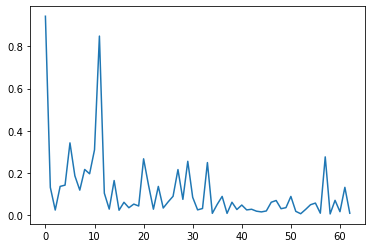

In [16]:
plt.plot(losses[::100])

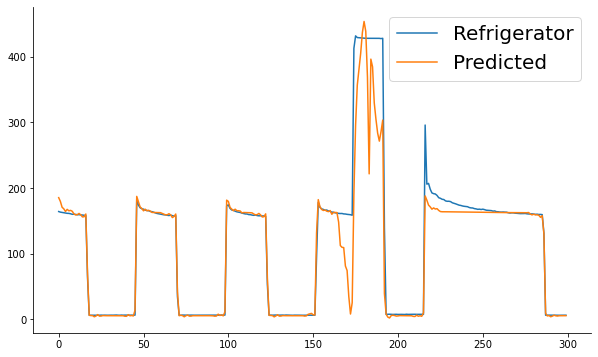

In [17]:
idx = 300
yhat = model.apply(params, x_test, True, rngs={"dropout":jax.random.PRNGKey(0)})
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), y_test[:idx], label = "Refrigerator")
plt.plot(jnp.arange(idx), scaler_y.inverse_transform(yhat[:idx]), label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
sns.despine()
plt.savefig("seq2point.pdf", bbox_inches="tight")

## GMLP

In [24]:
class seq2gpoint(nn.Module):
    @nn.compact
    def __call__(self, X, deterministic):
        X = nn.Conv(30, kernel_size=(10,))(X)
        X = nn.relu(X)
        X = nn.Conv(30, kernel_size=(8,))(X)
        X = nn.relu(X)        
        X = nn.Conv(40, kernel_size=(6,))(X)
        X = nn.relu(X)
        X = nn.Conv(50, kernel_size=(5,))(X)
        X = nn.relu(X)
        X = nn.Dropout(rate=0.2, deterministic=deterministic)(X)
        X = nn.Conv(50, kernel_size=(5,))(X)
        X = nn.relu(X)
        X = nn.Dropout(rate=0.2, deterministic=deterministic)(X)
        X = X.reshape((X.shape[0], -1))
        X = nn.Dense(1024)(X)
        X = nn.relu(X)
        X = nn.Dropout(rate=0.2, deterministic=deterministic)(X)
        X = nn.Dense(2)(X)
        mean = X[:, 0]
        sigma = nn.softplus(X[:, 1])
        return mean, sigma
    
    def loss_fn(self, params, X, y, deterministic, rng=jax.random.PRNGKey(0)):
        mean, sigma = self.apply(
            params, X, deterministic=deterministic, rngs={"dropout": rng}
        )

        def loss(mean, sigma, y):
            d = dist.Normal(loc=mean, scale=sigma)
            return -d.log_prob(y)

        return jnp.mean(jax.vmap(loss, in_axes=(0, 0, 0))(mean, sigma, y))

In [25]:
model = seq2gpoint()
params =  model.init(jax.random.PRNGKey(0), x_train, True)

In [26]:
%%time
params, losses = fit(model, params, x_train, y_train, False, batch_size=32, learning_rate=0.0001, epochs=50)

CPU times: user 18.5 s, sys: 2.83 s, total: 21.4 s
Wall time: 15.9 s


In [42]:
losses[-1]

DeviceArray(-1.3830504, dtype=float32)

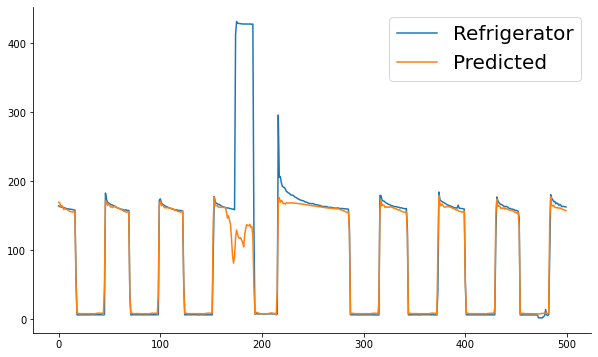

In [30]:
idx = 500
yhat = model.apply(params, x_test, True, rngs={"dropout":jax.random.PRNGKey(0)})
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), y_test[:idx], label = "Refrigerator")
plt.plot(jnp.arange(idx), scaler_y.inverse_transform(yhat[0][:idx].reshape(-1,1)), label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
sns.despine()
plt.savefig("seq2point.pdf", bbox_inches="tight")

## MC Dropout

In [31]:
n_stacks = 10
fn = lambda x, i : model.apply(params, x, False, rngs={"dropout": jax.random.PRNGKey(i)})
y_stacks = jax.vmap(jax.jit(fn), in_axes=(None, 0))(x_test, jnp.arange(n_stacks))

In [33]:
mean_stacks = y_stacks[0]
sigma_stacks = y_stacks[1]

In [35]:
mean, sigma = gmm_mean_var(mean_stacks, sigma_stacks)

In [37]:
mean = scaler_y.inverse_transform(mean.reshape(-1,1)).squeeze()
sigma = scaler_y.scale_*sigma

<AxesSubplot:>

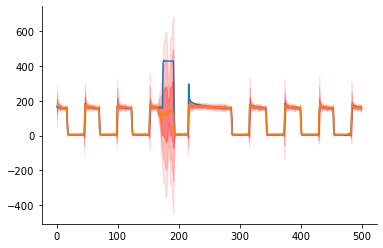

In [40]:
plot.plot(500,y_test,mean,sigma)

Text(0.5, 1.0, '0.9476')

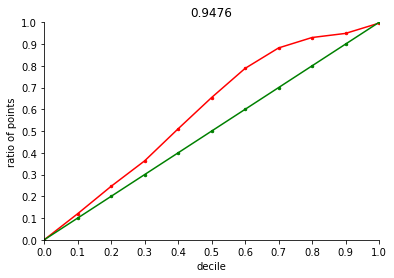

In [41]:
fig, ax = plt.subplots(1)
df,df2 = plot.calibration_regression(mean, sigma, y_test, "test", "r", ax)
ax.set_title(f'{errors.ace(df2):.4f}')

NameError: ignored

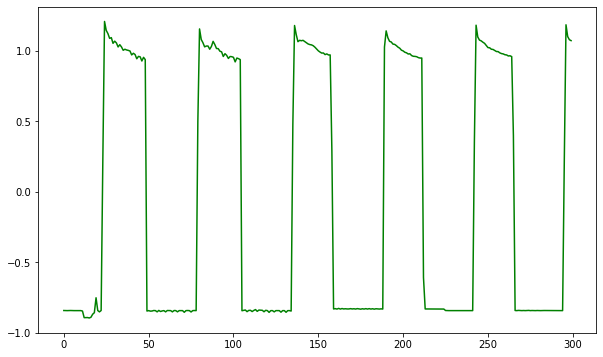

In [ ]:
idx = 300
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), scaler_y.transform(y_test[:idx].reshape(-1,1)), label = "Refrigerator", color="green")
plt.plot(jnp.arange(idx), mean[:idx], label = "Predicted")
for i in range(1,4):
    plt.fill_between(jnp.arange(idx), mean[:idx] - i*sigma[:idx], mean[:idx] + i*sigma[:idx],
                    color="orange", alpha=(1/(i*3)), label=f"$\mu\pm{i}*\sigma$")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.ylabel("Power", fontsize=20)
sns.despine()
# plt.savefig("seq2pointUncertain_wd.pdf", bbox_inches="tight")

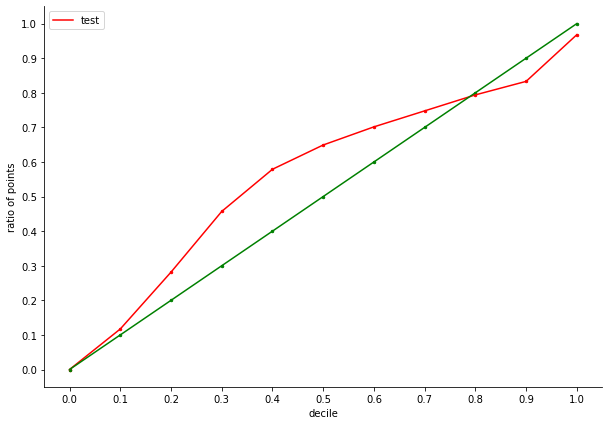

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,7))
r = plot.calibration_regression(mean, sigma, scaler_y.transform(y_test.reshape(-1,1)), "test", "r", ax)